# Horse or Human? In-graph training loop Assignment

This assignment lets you practice how to train a Keras model on the [horses_or_humans](https://www.tensorflow.org/datasets/catalog/horses_or_humans) dataset with the entire training process performed in graph mode.  These steps include:
- loading batches
- calculating gradients
- updating parameters
- calculating validation accuracy
- repeating the loop until convergence

## Setup

Import TensorFlow 2.0:

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import matplotlib.pyplot as plt

### Prepare the dataset

Load the horses to human dataset, splitting 80% for the training set and 20% for the test set.

In [3]:
splits, info = tfds.load('horses_or_humans', as_supervised=True, with_info=True, split=['train[:80%]', 'train[80%:]', 'test'], data_dir='./data')

(train_examples, validation_examples, test_examples) = splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = 224

## Pre-process an image (please complete this section)

You'll define a mapping function that resizes the image to a height of 224 by 224, and normalizes the pixels to the range of 0 to 1.  Note that pixels range from 0 to 255.

- You'll use the following function: [tf.image.resize](https://www.tensorflow.org/api_docs/python/tf/image/resize) and pass in the (height,width) as a tuple (or list).
- To normalize, divide by a floating value so that the pixel range changes from [0,255] to [0,1].

In [5]:
# Create a autograph pre-processing function to resize and normalize an image
### START CODE HERE ###
@tf.function
def map_fn(img, label):
    image_height = 224
    image_width = 224
### START CODE HERE ###
    # resize the image
    img = tf.image.resize(img, (image_height, image_width))
    # normalize the image
    img /= 255
### END CODE HERE
    return img, label

In [6]:
## TEST CODE:

test_image, test_label = list(train_examples)[0]

test_result = map_fn(test_image, test_label)

print(test_result[0].shape)
print(test_result[1].shape)

del test_image, test_label, test_result

(224, 224, 3)
()


**Expected Output:**

```
(224, 224, 3)
()
```

## Apply pre-processing to the datasets (please complete this section)

Apply the following steps to the training_examples:
- Apply the `map_fn` to the training_examples
- Shuffle the training data using `.shuffle(buffer_size=)` and set the buffer size to the number of examples.
- Group these into batches using `.batch()` and set the batch size given by the parameter.

Hint: You can look at how validation_examples and test_examples are pre-processed to get a sense of how to chain together multiple function calls.

In [7]:
# Prepare train dataset by using preprocessing with map_fn, shuffling and batching
def prepare_dataset(train_examples, validation_examples, test_examples, num_examples, map_fn, batch_size):
    ### START CODE HERE ###
    train_ds = train_examples.map(map_fn).shuffle(buffer_size=num_examples).batch(batch_size)
    ### END CODE HERE ###
    valid_ds = validation_examples.map(map_fn).batch(batch_size)
    test_ds = test_examples.map(map_fn).batch(batch_size)
    
    return train_ds, valid_ds, test_ds

In [8]:
train_ds, valid_ds, test_ds = prepare_dataset(train_examples, validation_examples, test_examples, num_examples, map_fn, BATCH_SIZE)

In [9]:
## TEST CODE:

test_train_ds = list(train_ds)
print(len(test_train_ds))
print(test_train_ds[0][0].shape)

del test_train_ds

26
(32, 224, 224, 3)


**Expected Output:**

```
26
(32, 224, 224, 3)
```

### Define the model

In [10]:
MODULE_HANDLE = 'data/resnet_50_feature_vector'
model = tf.keras.Sequential([
    hub.KerasLayer(MODULE_HANDLE, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              23561152  
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,565,250
Trainable params: 4,098
Non-trainable params: 23,561,152
_________________________________________________________________


## Define optimizer: (please complete these sections)
Define the [Adam optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) that is in the tf.keras.optimizers module.

In [11]:
def set_adam_optimizer():
    ### START CODE HERE ###
    # Define the adam optimizer
    optimizer = tf.keras.optimizers.Adam()
    ### END CODE HERE ###
    return optimizer

In [12]:
## TEST CODE:

test_optimizer = set_adam_optimizer()

print(type(test_optimizer))

del test_optimizer

<class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>


**Expected Output:**
```
<class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>
```

## Define the loss function (please complete this section)

Define the loss function as the [sparse categorical cross entropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy) that's in the tf.keras.losses module.  Use the same function for both training and validation.

In [13]:
def set_sparse_cat_crossentropy_loss():
    ### START CODE HERE ###
    # Define object oriented metric of Sparse categorical crossentropy for train and val loss
    train_loss = tf.keras.losses.SparseCategoricalCrossentropy()
    val_loss = tf.keras.losses.SparseCategoricalCrossentropy()
    ### END CODE HERE ###
    return train_loss, val_loss

In [14]:
## TEST CODE:

test_train_loss, test_val_loss = set_sparse_cat_crossentropy_loss()

print(type(test_train_loss))
print(type(test_val_loss))

del test_train_loss, test_val_loss

<class 'tensorflow.python.keras.losses.SparseCategoricalCrossentropy'>
<class 'tensorflow.python.keras.losses.SparseCategoricalCrossentropy'>


**Expected Output:**
```
<class 'tensorflow.python.keras.losses.SparseCategoricalCrossentropy'>
<class 'tensorflow.python.keras.losses.SparseCategoricalCrossentropy'>
```

## Define the acccuracy function (please complete this section)
Define the accuracy function as the [spare categorical accuracy](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/SparseCategoricalAccuracy) that's contained in the tf.keras.metrics module.   Use the same function for both training and validation.

In [15]:
def set_sparse_cat_crossentropy_accuracy():
    ### START CODE HERE ###
    # Define object oriented metric of Sparse categorical accuracy for train and val accuracy
    train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    ### END CODE HERE ###
    return train_accuracy, val_accuracy

In [16]:
## TEST CODE:

test_train_accuracy, test_val_accuracy = set_sparse_cat_crossentropy_accuracy()

print(type(test_train_accuracy))
print(type(test_val_accuracy))

del test_train_accuracy, test_val_accuracy

<class 'tensorflow.python.keras.metrics.SparseCategoricalAccuracy'>
<class 'tensorflow.python.keras.metrics.SparseCategoricalAccuracy'>


**Expected Output:**
```
<class 'tensorflow.python.keras.metrics.SparseCategoricalAccuracy'>
<class 'tensorflow.python.keras.metrics.SparseCategoricalAccuracy'>
```

Call the three functions that you defined to set the optimizer, loss and accuracy

In [17]:
optimizer = set_adam_optimizer()
train_loss, val_loss = set_sparse_cat_crossentropy_loss()
train_accuracy, val_accuracy = set_sparse_cat_crossentropy_accuracy()

### Define the training loop (please complete this section)

In the training loop:
- Get the model predictions: use the model, passing in the input `x`
- Get the training loss: Call `train_loss`, passing in the true `y` and the predicted `y`.
- Calculate the gradient of the loss with respect to the model's variables: use `tape.gradient` and pass in the loss and the model's `trainable_variables`.
- Optimize the model variables using the gradients: call `optimizer.apply_gradients` and pass in a `zip()` of the two lists: the gradients and the model's `trainable_variables`.
- Calculate accuracy: Call `train_accuracy`, passing in the true `y` and the predicted `y`.

In [20]:
# this code uses the GPU if available, otherwise uses a CPU
device = '/gpu:0' if tf.config.list_physical_devices('GPU') else '/cpu:0'
EPOCHS = 2

# Custom training step
def train_one_step(model, optimizer, x, y, train_loss, train_accuracy):
    '''
    Trains on a batch of images for one step.
    
    Args:
        model (keras Model) -- image classifier
        optimizer (keras Optimizer) -- optimizer to use during training
        x (Tensor) -- training images
        y (Tensor) -- training labels
        train_loss (keras Loss) -- loss object for training
        train_accuracy (keras Metric) -- accuracy metric for training
    '''
    with tf.GradientTape() as tape:
    ### START CODE HERE ###
        # Run the model on input x to get predictions
        predictions = model(x)
        # Compute the training loss using `train_loss`, passing in the true y and the predicted y
        loss = train_loss(y, predictions)

    # Using the tape and loss, compute the gradients on model variables using tape.gradient
    grads = tape.gradient(loss, model.trainable_weights)
    
    # Zip the gradients and model variables, and then apply the result on the optimizer
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    # Call the train accuracy object on ground truth and predictions
    train_accuracy(y, predictions)
    ### END CODE HERE
    return loss

In [21]:
## TEST CODE:

def base_model():
    inputs = tf.keras.layers.Input(shape=(2))
    x = tf.keras.layers.Dense(64, activation='relu')(inputs)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

test_model = base_model()

test_optimizer = set_adam_optimizer()
test_image = tf.ones((2,2))
test_label = tf.ones((1,))
test_train_loss, _ = set_sparse_cat_crossentropy_loss()
test_train_accuracy, _ = set_sparse_cat_crossentropy_accuracy()

test_result = train_one_step(test_model, test_optimizer, test_image, test_label, test_train_loss, test_train_accuracy)
print(test_result)

del test_result, test_model, test_optimizer, test_image, test_label, test_train_loss, test_train_accuracy

tf.Tensor(0.6931472, shape=(), dtype=float32)


**Expected Output:**

You will see a Tensor with the same shape and dtype. The value might be different.

```
tf.Tensor(0.6931472, shape=(), dtype=float32)
```

## Define the 'train' function (please complete this section)

You'll first loop through the training batches to train the model. (Please complete these sections)
- The `train` function will use a for loop to iteratively call the `train_one_step` function that you just defined.
- You'll use `tf.print` to print the step number, loss, and train_accuracy.result() at each step.  Remember to use tf.print when you plan to generate autograph code.

Next, you'll loop through the batches of the validation set to calculation the validation loss and validation accuracy. (This code is provided for you).  At each iteration of the loop:
- Use the model to predict on x, where x is the input from the validation set.
- Use val_loss to calculate the validation loss between the true validation 'y' and predicted y.
- Use val_accuracy to calculate the accuracy of the predicted y compared to the true y.

Finally, you'll print the validation loss and accuracy using tf.print. (Please complete this section)
- print the final `loss`, which is the validation loss calculated by the last loop through the validation dataset.
- Also print the val_accuracy.result().

**HINT**
If you submit your assignment and see this error for your stderr output: 
```
Cannot convert 1e-07 to EagerTensor of dtype int64
```
Please check your calls to train_accuracy and val_accuracy to make sure that you pass in the true and predicted values in the correct order (check the documentation to verify the order of parameters).

In [22]:
# Decorate this function with tf.function to enable autograph on the training loop
@tf.function
def train(model, optimizer, epochs, device, train_ds, train_loss, train_accuracy, valid_ds, val_loss, val_accuracy):
    '''
    Performs the entire training loop. Prints the loss and accuracy per step and epoch.
    
    Args:
        model (keras Model) -- image classifier
        optimizer (keras Optimizer) -- optimizer to use during training
        epochs (int) -- number of epochs
        train_ds (tf Dataset) -- the train set containing image-label pairs
        train_loss (keras Loss) -- loss function for training
        train_accuracy (keras Metric) -- accuracy metric for training
        valid_ds (Tensor) -- the val set containing image-label pairs
        val_loss (keras Loss) -- loss object for validation
        val_accuracy (keras Metric) -- accuracy metric for validation
    '''
    step = 0
    loss = 0.0
    for epoch in range(epochs):
        for x, y in train_ds:
            # training step number increments at each iteration
            step += 1
            with tf.device(device_name=device):
                ### START CODE HERE ###
                # Run one training step by passing appropriate model parameters
                # required by the function and finally get the loss to report the results
                loss = train_one_step(model, optimizer, x, y, train_loss, train_accuracy)
                ### END CODE HERE ###
            # Use tf.print to report your results.
            # Print the training step number, loss and accuracy
            tf.print('Step', step, 
                   ': train loss', loss, 
                   '; train accuracy', train_accuracy.result())

        with tf.device(device_name=device):
            for x, y in valid_ds:
                # Call the model on the batches of inputs x and get the predictions
                y_pred = model(x)
                loss = val_loss(y, y_pred)
                val_accuracy(y, y_pred)
        
        # Print the validation loss and accuracy
        ### START CODE HERE ###
        tf.print('val loss', loss, '; val accuracy', val_accuracy.result())
        ### END CODE HERE ###

Run the `train` function to train your model! You should see the loss generally decreasing and the accuracy increasing.

**Note**: **Please let the training finish before submitting** and **do not** modify the next cell. It is required for grading. This will take around 5 minutes to run. 

In [23]:
train(model, optimizer, EPOCHS, device, train_ds, train_loss, train_accuracy, valid_ds, val_loss, val_accuracy)

Step 1 : train loss 0.980503082 ; train accuracy 0.5
Step 2 : train loss 0.713017702 ; train accuracy 0.546875
Step 3 : train loss 0.563035965 ; train accuracy 0.583333313
Step 4 : train loss 0.303898 ; train accuracy 0.6484375
Step 5 : train loss 0.325197875 ; train accuracy 0.6875
Step 6 : train loss 0.156460896 ; train accuracy 0.734375
Step 7 : train loss 0.253034592 ; train accuracy 0.754464269
Step 8 : train loss 0.146499828 ; train accuracy 0.78125
Step 9 : train loss 0.0940893292 ; train accuracy 0.802083313
Step 10 : train loss 0.0546386205 ; train accuracy 0.821875
Step 11 : train loss 0.033502996 ; train accuracy 0.838068187
Step 12 : train loss 0.0306112356 ; train accuracy 0.8515625
Step 13 : train loss 0.0253454223 ; train accuracy 0.862980783
Step 14 : train loss 0.0325085223 ; train accuracy 0.872767866
Step 15 : train loss 0.0252135806 ; train accuracy 0.88125
Step 16 : train loss 0.022147892 ; train accuracy 0.888671875
Step 17 : train loss 0.0188972224 ; train accura

# Evaluation

You can now see how your model performs on test images. First, let's load the test dataset and generate predictions:

In [24]:
test_imgs = []
test_labels = []

predictions = []
with tf.device(device_name=device):
    for images, labels in test_ds:
        preds = model(images)
        preds = preds.numpy()
        predictions.extend(preds)

        test_imgs.extend(images.numpy())
        test_labels.extend(labels.numpy())

Let's define a utility function for plotting an image and its prediction.

In [25]:
# Utilities for plotting

class_names = ['horse', 'human']

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    img = np.squeeze(img)

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    
    # green-colored annotations will mark correct predictions. red otherwise.
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
    
    # print the true label first
    print(true_label)
  
    # show the image and overlay the prediction
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)



### Plot the result of a single image

Choose an index and display the model's prediction for that image.

1


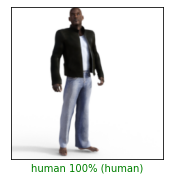

In [28]:
# Visualize the outputs 

# you can modify the index value here from 0 to 255 to test different images
index = 11 
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_imgs)
plt.show()